# Project: Linear Regression Price Predictor for Used Cars

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

### Section 1: DataFrame Loading, Cleaning

In [2]:
# Returns you all the variables in the current environment

# dir()  

# Refer to this link: https://stackoverflow.com/questions/633127/viewing-all-defined-variables
# To find out out to view all defined variables in the current environment

In [3]:
df_main = pd.read_csv('cars.csv')
df_main.sample(5)

,manufacturer_name,model_name,transmission,body_type,production_year,number_of_seat,odometer_value,color_body,engine_fuel,engine_type,engine_capacity,drivetrain,price,url
8972,Mercedes-Benz,c-class,Số tự động,Sedan,2006,5,174468.0,Đen,Xăng,NaN,NaN,NaN,210000000.0,http://oto.com.vn/mua-ban-xe-mercedes-benz-c-c...
15658,Hyundai,accent,Số tay,Sedan,2018,5,11000.0,Vàng,Xăng,NaN,NaN,FWD - Dẫn động cầu trước,476000000.0,http://oto.com.vn/mua-ban-xe-hyundai-accent-hc...
4366,Toyota,vios,Số tay,Sedan,2010,5,98500.0,Bạc,Xăng,NaN,NaN,FWD - Dẫn động cầu trước,300000000.0,http://oto.com.vn/mua-ban-xe-toyota-vios-phu-t...
18420,Toyota,vios,Số tự động,Sedan,2017,5,NaN,Bạc,Xăng,NaN,NaN,NaN,470000000.0,http://oto.com.vn/mua-ban-xe-toyota-vios-ha-no...
4128,Toyota,camry,Số tự động,Sedan,2018,5,31000.0,Nâu,Xăng,NaN,NaN,NaN,880000000.0,http://oto.com.vn/mua-ban-xe-toyota-camry-dong...


In [4]:
df_main.columns

Index(['manufacturer_name', 'model_name', 'transmission', 'body_type',
       'production_year', 'number_of_seat', 'odometer_value', 'color_body',
       'engine_fuel', 'engine_type', 'engine_capacity', 'drivetrain', 'price',
       'url'],
      dtype='object')

In [5]:
df_main.describe()

,production_year,number_of_seat,odometer_value,engine_type,engine_capacity,price
count,20540.000000,20540.000000,1.719800e+04,0.0,1138.000000,2.054000e+04
mean,2013.443427,5.433009,7.035604e+04,NaN,1591.660808,1.455116e+09
std,4.853385,1.231451,1.859967e+05,NaN,491.286989,3.845170e+09
min,1965.000000,0.000000,1.000000e+00,NaN,20.000000,0.000000e+00
25%,2010.000000,5.000000,3.000000e+04,NaN,1496.000000,3.700000e+08
50%,2015.000000,5.000000,5.500000e+04,NaN,1496.000000,4.760000e+08
75%,2017.000000,5.000000,1.080000e+05,NaN,1496.000000,8.800000e+08
max,2019.000000,47.000000,1.800000e+07,NaN,5700.000000,1.790000e+10


In [6]:
df_clean = df_main.drop(['color_body',
       'engine_fuel', 'engine_type', 'engine_capacity', 'drivetrain', 'url'],axis=1) # Dropping columns that I used for my own reference

# We see that we have NA entries in this dataset. 
# We want to drop these NA values or they will pose problems for us later
# The null values can be attributed to the fact that some data is not keyed in the listing itself, 
# or formatting issues due to the varying ways of which people organize the information of the car in a single listing

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20540 entries, 0 to 20539
Data columns (total 8 columns):
manufacturer_name    20540 non-null object
model_name           20540 non-null object
transmission         19288 non-null object
body_type            20539 non-null object
production_year      20540 non-null int64
number_of_seat       20540 non-null int64
odometer_value       17198 non-null float64
price                20540 non-null float64
dtypes: float64(2), int64(2), object(4)
memory usage: 1.3+ MB


In [7]:
# We now have 20540 rows

df_clean.dropna(inplace=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17027 entries, 0 to 20539
Data columns (total 8 columns):
manufacturer_name    17027 non-null object
model_name           17027 non-null object
transmission         17027 non-null object
body_type            17027 non-null object
production_year      17027 non-null int64
number_of_seat       17027 non-null int64
odometer_value       17027 non-null float64
price                17027 non-null float64
dtypes: float64(2), int64(2), object(4)
memory usage: 1.2+ MB


In [8]:
# Taking a look at our data
df_clean.sample(5)

,manufacturer_name,model_name,transmission,body_type,production_year,number_of_seat,odometer_value,price
3927,Hyundai,accent,Số tay,Sedan,2018,5,11000.0,476000000.0
6268,Ford,ranger,Số tự động,Pick-up Truck,2017,5,55000.0,790000000.0
19692,Toyota,fortuner,Số tay,SUV,2017,7,55000.0,885000000.0
12721,Mazda,3,Số tự động,Hatchback,2016,5,35000.0,550000000.0
13089,Kia,cerato,Số tự động,Sedan,2010,5,108000.0,380000000.0


In [9]:
print(df_clean.columns,'\n',len(df_clean.columns))

# We have 12 features in our columns

Index(['manufacturer_name', 'model_name', 'transmission', 'body_type',
       'production_year', 'number_of_seat', 'odometer_value', 'price'],
      dtype='object') 
 8


### Section 2: Data Categorizing

## Section 2.1: One-hot encoding TRANSMISSION Column

In [10]:
# Here, we see that there only two options for transmission - Auto or Manual (i.e., Auto or not). 
# Therefore, we can do 1-hot encoding for this

df_clean['transmission'].value_counts()

Số tự động    11396
Số tay         5625
Số hỗn hợp        6
Name: transmission, dtype: int64

In [11]:
# Transmission conversion -> 1 for auto, 0 for manual

df_clean['transmission_convert'] = df_clean['transmission'].apply(lambda x: 1 if x == 'Số tự động' else 0)
df_clean.drop('transmission',axis=1,inplace=True)
df_clean.rename(columns={'transmission_convert':"transmission"}, inplace=True)  # Renaming column back
df_clean.sample(5)

,manufacturer_name,model_name,body_type,production_year,number_of_seat,odometer_value,price,transmission
17233,Ford,ranger,Pick-up Truck,2017,5,55000.0,7.900000e+08,1
20503,Kia,morning,Hatchback,2019,5,9612.0,3.700000e+08,1
6096,Kia,cerato,Sedan,2010,5,108000.0,3.800000e+08,1
14017,Toyota,innova,MPV,2015,7,170000.0,4.900000e+08,0
4466,Rolls-Royce,phantom,Sedan,2011,4,30000.0,1.790000e+10,1


In [12]:
# Performing whitespace stripping prior to dtype manipulation
#df_clean['body_type'].apply(str.strip)
#df_clean['body_type'].apply(str.lstrip)

# Inspection of the type of Vehicles
df_clean['body_type'].value_counts()
#df_clean['engine_capacity'].value_counts()

Sedan              9885
SUV                2501
Hatchback          2265
MPV                1145
Pick-up Truck      1111
Van/Minivan          69
CUV                  32
Truck                13
City Car              2
Sport Car             2
Special Purpose       1
Coupe                 1
Name: body_type, dtype: int64

In [13]:
df_clean.head()

,manufacturer_name,model_name,body_type,production_year,number_of_seat,odometer_value,price,transmission
0,Kia,cerato,Sedan,2018,5,15000.0,608000000.0,1
1,Toyota,innova,MPV,2016,7,151000.0,583000000.0,0
2,Toyota,innova,MPV,2014,8,82000.0,520000000.0,1
3,Toyota,corolla-altis,Sedan,2009,5,127000.0,470000000.0,1
4,Kia,rio,Sedan,2015,5,70000.0,366000000.0,0


## Section 2.2: Datetime conversion

In [14]:
# Converting reg_date to datetime, and Manufactured year to int

#df_clean['REG_DATE'] = pd.to_datetime(df_clean['REG_DATE'])
df_clean['production_year'] = df_clean['production_year'].astype(int)
df_clean[['production_year']].dtypes

production_year    int32
dtype: object

In [15]:
df_clean.dtypes

manufacturer_name     object
model_name            object
body_type             object
production_year        int32
number_of_seat         int64
odometer_value       float64
price                float64
transmission           int64
dtype: object

In [16]:
# ONLY RUN THIS CELL ONCE!
#df_main['SCRAPE_DATE'] = \
#pd.to_datetime(df_main['SCRAPE_DATE']).dt.year # Convert scrape date to integer to perform operations on them


In [17]:
#df_main['SCRAPE_DATE'] # Checking dtype

### Section 2.2.1: Adding a Car Age Column

In [18]:
# Converting current scrape date from main dataframe to datetime object using pandas
from datetime import date

# Obtaining number of years from year of manufacture to current year (metric for how new the car is)
current_year = date.today().year
df_clean['car_age'] = current_year - df_clean['production_year'] # Obtaining values for age of car
df_clean['car_age'].astype(int)

0         2
1         4
2         6
3        11
4         5
         ..
20535     3
20536     3
20537     9
20538     1
20539    13
Name: car_age, Length: 17027, dtype: int32

In [19]:
# Rearranging Columns 
#df_clean = df_clean[['BRAND', 'PRICE', 'DEPRE_VALUE_PER_YEAR', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT', 
#                    'REG_DATE', 'MANUFACTURED_YEAR', 'CAR_AGE', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV', 'ARF', 
#                    'ENGINE_CAPACITY_CC', 'ROAD_TAX_PER_YEAR', 'CURB_WEIGHT_KG',
#                    'NO_OF_OWNERS', 'VEHICLE_TYPE', 'TRANSMISSION']]
df_clean.head()

,manufacturer_name,model_name,body_type,production_year,number_of_seat,odometer_value,price,transmission,car_age
0,Kia,cerato,Sedan,2018,5,15000.0,608000000.0,1,2
1,Toyota,innova,MPV,2016,7,151000.0,583000000.0,0,4
2,Toyota,innova,MPV,2014,8,82000.0,520000000.0,1,6
3,Toyota,corolla-altis,Sedan,2009,5,127000.0,470000000.0,1,11
4,Kia,rio,Sedan,2015,5,70000.0,366000000.0,0,5


## Section 2.3:BODY_TYPE To Dummy Variables

In [20]:
# Making Dummy Variables out of Vehicle Types:

x_vehtype_dummy = patsy.dmatrix('body_type',data=df_clean,return_type='dataframe')
x_vehtype_dummy.head()

# Do we drop the "Intercept" column?

,Intercept,body_type[T.City Car],body_type[T.Coupe],body_type[T.Hatchback],body_type[T.MPV],body_type[T.Pick-up Truck],body_type[T.SUV],body_type[T.Sedan],body_type[T.Special Purpose],body_type[T.Sport Car],body_type[T.Truck],body_type[T.Van/Minivan]
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
#df_clean_memory = df_clean.memory_usage(index=True).sum()
x_vehtype_dummy_memory = x_vehtype_dummy.memory_usage(index=True).sum()
#print("df_clean_memory dataset uses ",df_clean_memory/ 1024**2," MB")
#print("x_vehtype_dummy_memory dataset uses ",x_vehtype_dummy_memory/ 1024**2," MB")
df_clean2 = df_clean.join(x_vehtype_dummy)
df_clean2 

,manufacturer_name,model_name,body_type,production_year,number_of_seat,odometer_value,price,transmission,car_age,Intercept,...,body_type[T.Coupe],body_type[T.Hatchback],body_type[T.MPV],body_type[T.Pick-up Truck],body_type[T.SUV],body_type[T.Sedan],body_type[T.Special Purpose],body_type[T.Sport Car],body_type[T.Truck],body_type[T.Van/Minivan]
0,Kia,cerato,Sedan,2018,5,15000.0,6.080000e+08,1,2,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Toyota,innova,MPV,2016,7,151000.0,5.830000e+08,0,4,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Toyota,innova,MPV,2014,8,82000.0,5.200000e+08,1,6,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Toyota,corolla-altis,Sedan,2009,5,127000.0,4.700000e+08,1,11,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Kia,rio,Sedan,2015,5,70000.0,3.660000e+08,0,5,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20535,Ford,ranger,Pick-up Truck,2017,5,55000.0,7.900000e+08,1,3,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
20536,Toyota,fortuner,SUV,2017,7,55000.0,8.850000e+08,0,3,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20537,Rolls-Royce,phantom,Sedan,2011,4,30000.0,1.790000e+10,1,9,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20538,Toyota,fortuner,SUV,2019,7,7000.0,1.030000e+09,1,1,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Section 2.4: Car Brand Categorization. Includes:
* Splitting them into Dummy Variables
* Indexing them into price range categories (perhaps better metric over vehicle types)
* Converting lesser-known brands into "others"

In [22]:
# Renaming Brand Names to their actual names

#df_clean2.loc[df_clean2['BRAND'] == 'Aston','BRAND'] = 'Aston Martin'
#df_clean2.loc[df_clean2['BRAND'] == 'Land','BRAND'] = 'Land Rover'
#df_clean2.loc[df_clean2['BRAND'] == 'Alfa', 'BRAND'] = 'Alfa Romeo'
#df_clean2.head()

In [23]:
# Cleaning whitespaces from the values in "Brand" to prevent any messup later
#df_clean2['manufacturer_name'].apply(str.strip)

# Checking the number of brands in the dataset
print("# Of rows in DataFrame in Brands Column:\n", df_clean2.loc[:,'manufacturer_name'])
print("\nValue Counts of Brands:\n", df_clean2.loc[:,'manufacturer_name'].value_counts())
print("\n# of Brands:", len(df_clean2.loc[:,'manufacturer_name'].value_counts()))

# New Column ATAS
# New Column Budget Cars
# Top 20 brands
# Am I comfortable with grouping uncommon cars into others?

# Of rows in DataFrame in Brands Column:
 0                Kia
1             Toyota
2             Toyota
3             Toyota
4                Kia
            ...     
20535           Ford
20536         Toyota
20537    Rolls-Royce
20538         Toyota
20539         Toyota
Name: manufacturer_name, Length: 17027, dtype: object

Value Counts of Brands:
 Toyota           8693
Kia              2228
Mercedes-Benz    1207
Hyundai          1182
Ford             1178
Mazda            1098
Rolls-Royce      1046
Lexus              70
Honda              55
Chevrolet          54
Mitsubishi         32
LandRover          28
BMW                25
Audi               23
Nissan             23
Daewoo             17
Suzuki             13
Cadillac            7
Porsche             7
Bentley             5
Isuzu               4
Jaguar              4
Acura               4
Peugeot             3
Renault             3
Cửu Long            2
Mini                2
Zotye               2
Volkswagen          2
Samco    

## Section 3: Data Visualization
* EDA  
* Correlation Matrix  
* Pairplots  

## Section 3.1: Preliminary Correlation Exploration

### Section 3.1.1: Analysis without Car Brands and Vehicle Types for Feature Dropping

In [24]:
df_clean2.columns

Index(['manufacturer_name', 'model_name', 'body_type', 'production_year',
       'number_of_seat', 'odometer_value', 'price', 'transmission', 'car_age',
       'Intercept', 'body_type[T.City Car]', 'body_type[T.Coupe]',
       'body_type[T.Hatchback]', 'body_type[T.MPV]',
       'body_type[T.Pick-up Truck]', 'body_type[T.SUV]', 'body_type[T.Sedan]',
       'body_type[T.Special Purpose]', 'body_type[T.Sport Car]',
       'body_type[T.Truck]', 'body_type[T.Van/Minivan]'],
      dtype='object')

In [25]:
df_price_no_brands = df_clean2[['model_name', 'body_type', 'production_year',
       'number_of_seat', 'odometer_value', 'price', 'transmission',
       'car_age']]
df_price_no_brands.head()

,model_name,body_type,production_year,number_of_seat,odometer_value,price,transmission,car_age
0,cerato,Sedan,2018,5,15000.0,608000000.0,1,2
1,innova,MPV,2016,7,151000.0,583000000.0,0,4
2,innova,MPV,2014,8,82000.0,520000000.0,1,6
3,corolla-altis,Sedan,2009,5,127000.0,470000000.0,1,11
4,rio,Sedan,2015,5,70000.0,366000000.0,0,5


In [26]:
# Corr Matrix
df_price_no_brands.corr()

,production_year,number_of_seat,odometer_value,price,transmission,car_age
production_year,1.000000,0.236836,-0.456331,-0.154276,-0.101028,-1.000000
number_of_seat,0.236836,1.000000,0.066034,-0.277563,-0.298586,-0.236836
odometer_value,-0.456331,0.066034,1.000000,-0.127782,-0.094796,0.456331
price,-0.154276,-0.277563,-0.127782,1.000000,0.199976,0.154276
transmission,-0.101028,-0.298586,-0.094796,0.199976,1.000000,0.101028
car_age,-1.000000,-0.236836,0.456331,0.154276,0.101028,1.000000


In [27]:
# How each feature relates to price
df_price_no_brands.corr()['price'].sort_values(ascending=False)

price              1.000000
transmission       0.199976
car_age            0.154276
odometer_value    -0.127782
production_year   -0.154276
number_of_seat    -0.277563
Name: price, dtype: float64

(6.0, 0.0)

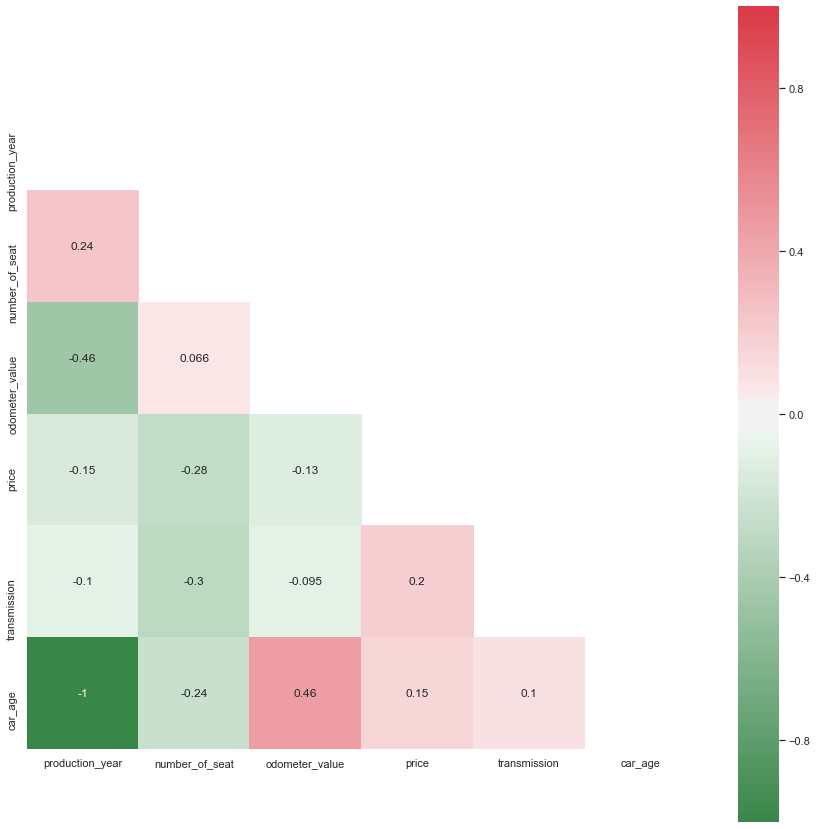

In [28]:
# Corr Matrix Heatmap Visualization

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(df_price_no_brands.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(15,15))

# Create a custom color palette
cmap = \
sns.diverging_palette(133, 10,
                      as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Green = Good (low correlation), Red = Bad (high correlation) between the independent variables

# Plot the heatmap
sns.heatmap(df_price_no_brands.corr(), mask=mask, annot=True, 
            square=True, cmap=cmap , vmin=-1, vmax=1,ax=ax);

# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Section 3.1.2: Removing Independent Variables with High Correlation to each other

In [29]:
df_price_no_brands.drop(['production_year','body_type'],axis=1,inplace=True)
df_price_no_brands.columns

D:\Application\Anaconda2\envs\py3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Index(['model_name', 'number_of_seat', 'odometer_value', 'price',
       'transmission', 'car_age'],
      dtype='object')

### Section 3.1.3: Re-Visualizing New Correlation Matrix (with a few features dropped)

#### From the above Corr Matrix, we can observe that a few Independent Variables are highly correlated with each other. 
Interestingly, this makes sense due to how a few of the independent variables are calculated. Therefore, some of these features can be dropped.  
1. **OMV and ARF:** 
The Additional Registration Fee (ARF) is a tax imposed upon registration of a vehicle. It is calculated based on a percentage of the Open Market Value (OMV) of the vehicle. From the correlation matrix, they have a correlation of **0.96.** Therefore, we can just keep one of this. Therefore, **ARF** will be dropped.
   
   
2. **Engine CC and Road Tax:** 
Road tax increases as engine CC increases. Therefore, having Road Tax in it would be introducing multicolinearity into the model, since both explain the same thing anyway. From the correlation matrix, they have a correlation of **0.97**. Therefore, **road tax** column will be dropped.
   
   
3. **Manufactured Year and Car Age:** 
Obviously, manufactured year can be dropped, since Car Age is derived from year of manufacture. And since car age is more intuitive, **Manufactured Year** column will be dropped.  From the correlation matrix, they have a correlation of **-1**. 
  

  
4. **Dereg Value:**  
The deregistration value of a vehicle is amount one will get back from the government upon deregistering the vehicle for use in Singapore. It is the sum of the COE rebate and the PARF rebate.
The COE rebate is a percentage of the original COE value.
The PARF rebate is a percentage of the original OMV (Open Market Value).
Therefore, the **dereg value will be dropped**. From the corr matrix, OMV and dereg value have a correlation of **0.91.**
  
  
5. **Depreciation:** 
Annual depreciation is the amount the owner loses on the value of the vehicle per year based on the assumption that the vehicle is deregistered only at the end of its 10-yr COE life-span. The value of the car body has not been taken into account.  The formula used to derive the figure is as follows:  
Depreciation = (List Price - Minimum PARF value) ÷ remaining years of COE  
The minimum Preferential Additional Registration Fee (PARF) value is a sum of money that the vehicle owner gets for deregistering his vehicle at the end of its 10-yr COE. It is a function of the Open Market Value (OMV) or Additional Registration Fee (ARF). Commercial vehicles and cars with renewed COE have no minimum PARF value.  Depreciation and OMV have a correlation of **0.91**. **Depreciation** will be dropped.


(5.0, 0.0)

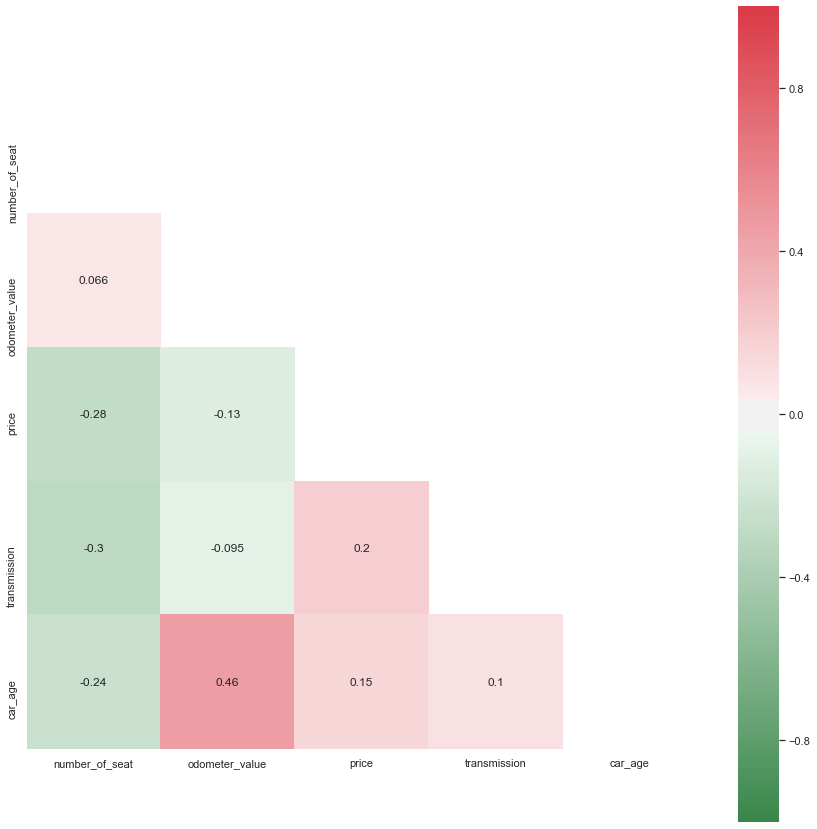

In [30]:
# Re-visualizing the correlation matrix

sns.set(style="white")

# Creating the data
data = df_price_no_brands.corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(15,15))

# Create a custom color palette
cmap = \
sns.diverging_palette(133, 10,
                      as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Green = Good (low correlation), Red = Bad (high correlation) between the independent variables

# Plot the heatmap
sns.heatmap(data, mask=mask, annot=True, 
            square=True, cmap=cmap , vmin=-1, vmax=1,ax=ax);

# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [31]:
# Correlations of the independent variables (features) to dependent variable (target, price)
df_price_no_brands.corr()['price'].sort_values(ascending=False)

price             1.000000
transmission      0.199976
car_age           0.154276
odometer_value   -0.127782
number_of_seat   -0.277563
Name: price, dtype: float64

#### Section 3.1.3.1: Pairplot after Feature Selection

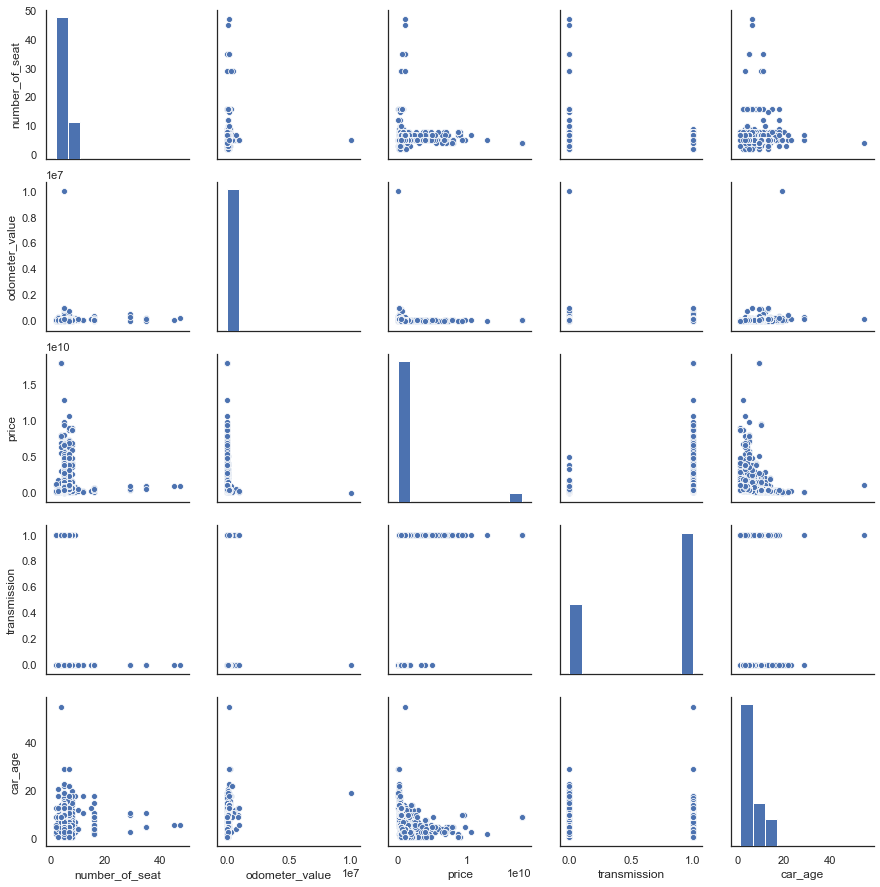

In [32]:
# Performing a pairplot to visualize the data trends of the variables

# We can see that price and mileage hold a negative linear relationship
# COE from the scrape date doesn't seem to have a very clear relatonship here
# Days of COE seems to have a slight linear r/s
# Car age doesn't seem to have a very distinct relationship here. But generally, the younger the car, the higher the price
# OMV has a clear increasing linear rs with price with price
# Engine capacity seems to also have a increasing linear r/s  with price, with a few outliers in the center
# Perhaps it's because a lot of the higher-priced cars (higher brands) are produced in that engine capacity range?
# Curb weight seems to have a linear r/s too.

sns.pairplot(df_price_no_brands);

In [33]:
df_price_no_brands.columns

Index(['model_name', 'number_of_seat', 'odometer_value', 'price',
       'transmission', 'car_age'],
      dtype='object')

### Section 3.2: Preliminary Model fitting to check R^2 Value and P>|t| values of Price and the leftover Independent Variables

In [34]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
#df_price_no_brands.dropna(inplace=True)
X = df_price_no_brands[ ['number_of_seat', 'odometer_value', 'transmission',
       'car_age'] ].astype(float)
X = sm.add_constant(X)
y = df_price_no_brands['price'].astype(int)



C:\Users\nam.nguyen\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [35]:
X.head()

,const,number_of_seat,odometer_value,transmission,car_age
0,1.0,5.0,15000.0,1.0,2.0
1,1.0,7.0,151000.0,0.0,4.0
2,1.0,8.0,82000.0,1.0,6.0
3,1.0,5.0,127000.0,1.0,11.0
4,1.0,5.0,70000.0,0.0,5.0


In [36]:
y.head()

0    608000000
1    583000000
2    520000000
3    470000000
4    366000000
Name: price, dtype: int32

In [37]:
# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     1214.
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:40:26   Log-Likelihood:            -3.7004e+05
No. Observations:               17027   AIC:                         7.401e+05
Df Residuals:                   17022   BIC:                         7.401e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.122e+08    3.1e+07     -6.845      0.000   -2.73e+08   -1.51e+08
number_of_seat  1.635e+08   4.74e+06     34.515      0.000    1.54e+08    1.73e+08
odometer_value  1197.3803     61.450     19.485      0.000    1076.931    1317.829
transmission    4.931e+07   1.14e+07      4.323      0.000    2.69e+07    7.17e+07
car_age        -6.767e+07   1.43e+06    -47.328      0.000   -7.05e+07   -6.49e+07
==============================================================================
Omnibus:                    10522.211   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           125557.526
Skew:                          -2.826   Prob(JB):                         0.00
Kurtosis:                      15.043   Cond. No.                     7.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Section 3.2.1: Optimizing R^2 Value

#### Section 3.2.1.1: Checking Distributions & Pairplots of all Variables

##### Pairplot of Price vs Independent Variables (without any transformation)

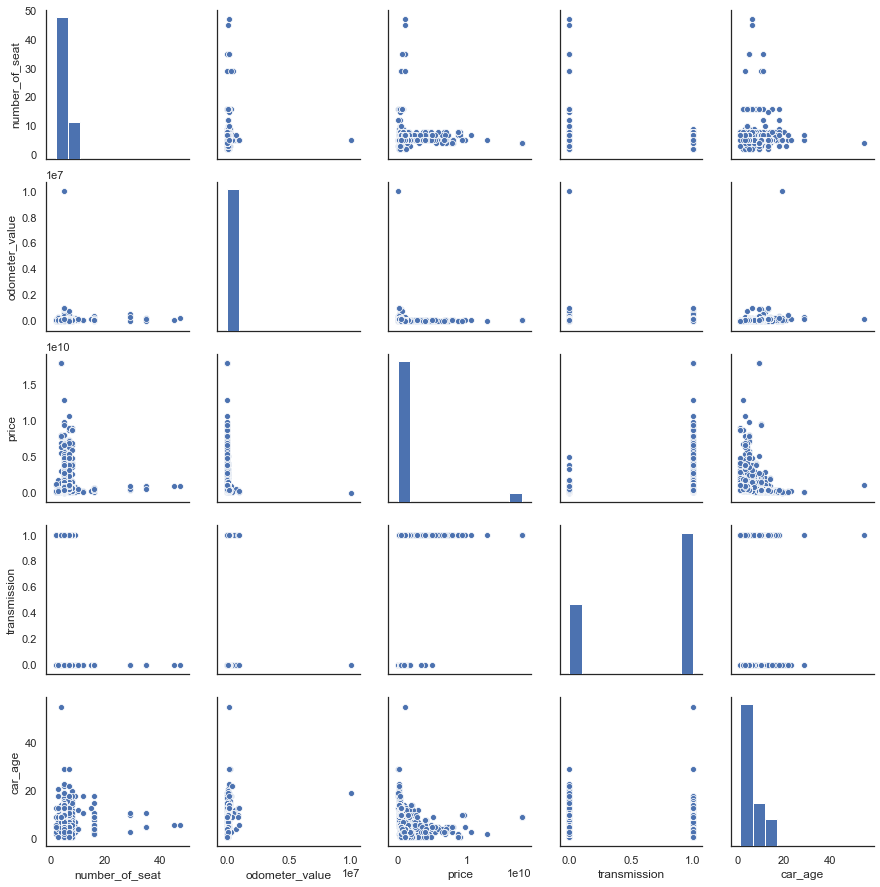

In [38]:
# Performing a pairplot to visualize the data trends of the variables

# We can see that price and mileage hold a negative linear relationship
# COE from the scrape date doesn't seem to have a very clear relatonship here
# Days of COE seems to have a slight linear r/s
# Car age doesn't seem to have a very distinct relationship here. But generally, the younger the car, the higher the price
# OMV has a clear increasing linear rs with price with price
# Engine capacity seems to also have a increasing linear r/s  with price, with a few outliers in the center
# Perhaps it's because a lot of the higher-priced cars (higher brands) are produced in that engine capacity range?
# Curb weight seems to have a linear r/s too.

sns.pairplot(df_price_no_brands);

##### Histograph of all Variables (Columns) in DataFrame

D:\Application\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024BC01699C8>,
      dtype=object)

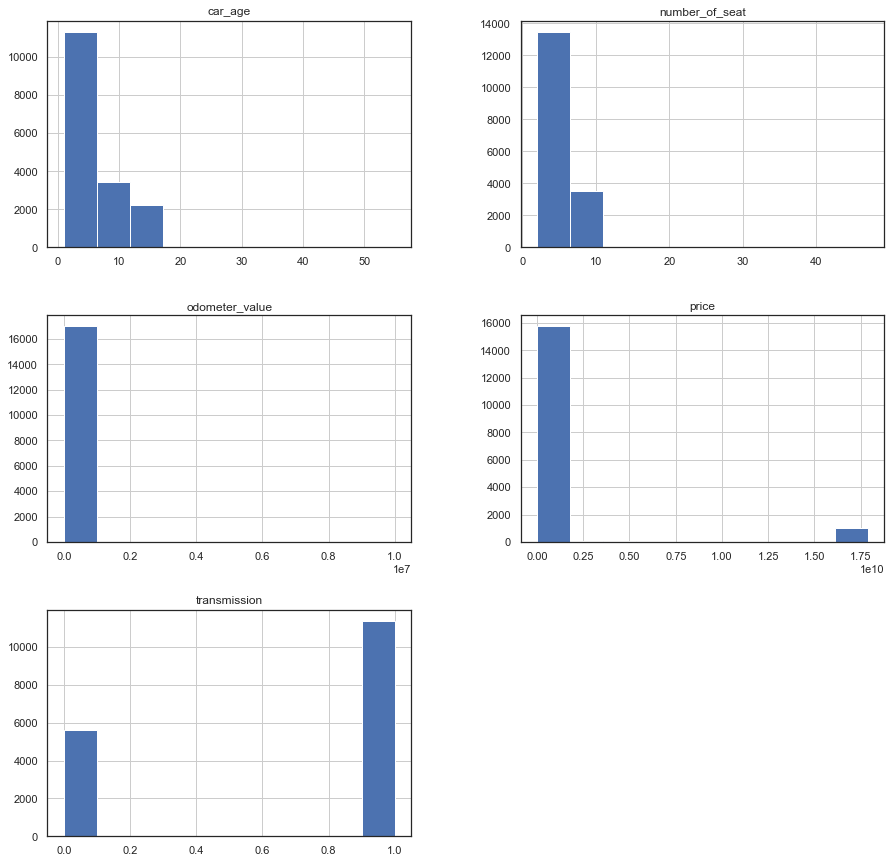

In [39]:
fig, ax = plt.subplots(figsize=(15,15))
pd.DataFrame.hist(df_price_no_brands,ax=ax)

In [40]:
# From the above graphs, it would make sense to apply log transform on the following variables to make them
# more normally distributed
# Mileage
# Engine Cap
# Price
# OMV

## Distribution of Price

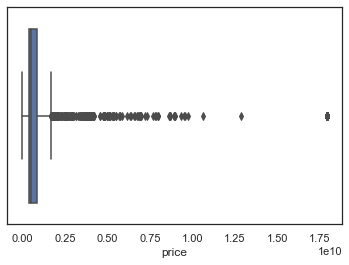

In [41]:
sns.boxplot(df_price_no_brands['price'])  # 

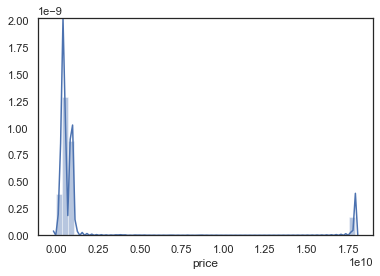

In [42]:
sns.distplot(df_price_no_brands['price'])  # Your dependent variable 'must' be normally distributed

In [43]:
# We see that price is right-skewed. Therefore, we can try applying a log onto price, then visualize the data again.

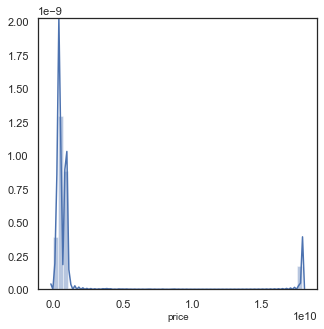

In [44]:
fig, ax = plt.subplots(figsize=(5,5))
sns.distplot(df_price_no_brands['price'],ax=ax)
plt.xlabel('price',size=10)
plt.savefig("price_no_log.png",transparent=True)

### Section 3.2.1: Logging Mileage ONLY

In [45]:
# Creating a copy of the dataframe to work log on
df_price_no_brands_only_mileage_logged = df_price_no_brands.copy()

In [46]:
# Log Mileage
df_price_no_brands_only_mileage_logged["odometer_value_log"] = df_price_no_brands_only_mileage_logged['odometer_value'].apply(np.log)
df_price_no_brands_only_mileage_logged

,model_name,number_of_seat,odometer_value,price,transmission,car_age,odometer_value_log
0,cerato,5,15000.0,6.080000e+08,1,2,9.615805
1,innova,7,151000.0,5.830000e+08,0,4,11.925035
2,innova,8,82000.0,5.200000e+08,1,6,11.314475
3,corolla-altis,5,127000.0,4.700000e+08,1,11,11.751942
4,rio,5,70000.0,3.660000e+08,0,5,11.156251
...,...,...,...,...,...,...,...
20535,ranger,5,55000.0,7.900000e+08,1,3,10.915088
20536,fortuner,7,55000.0,8.850000e+08,0,3,10.915088
20537,phantom,4,30000.0,1.790000e+10,1,9,10.308953
20538,fortuner,7,7000.0,1.030000e+09,1,1,8.853665


In [47]:
# Rearranging columns

df_price_no_brands_only_mileage_logged = \
df_price_no_brands_only_mileage_logged[['price', 'odometer_value_log',
       'car_age', 'transmission']]

In [48]:
df_price_no_brands_only_mileage_logged.columns

Index(['price', 'odometer_value_log', 'car_age', 'transmission'], dtype='object')

In [49]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_price_no_brands_only_mileage_logged[ [ 'odometer_value_log',
       'car_age', 'transmission'] ].astype(float)
X = sm.add_constant(X)
y = df_price_no_brands_only_mileage_logged['price'].astype(int)


# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

C:\Users\nam.nguyen\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     1648.
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:40:37   Log-Likelihood:            -3.7001e+05
No. Observations:               17027   AIC:                         7.400e+05
Df Residuals:                   17023   BIC:                         7.401e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.327e+09   7.29e+07    -31.937      0.000   -2.47e+09   -2.18e+09
odometer_value_log  3.151e+08   7.19e+06     43.806      0.000    3.01e+08    3.29e+08
car_age            -1.217e+08   1.79e+06    -68.187      0.000   -1.25e+08   -1.18e+08
transmission        7.358e+07   1.15e+07      6.378      0.000     5.1e+07    9.62e+07
==============================================================================
Omnibus:                     6906.536   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38019.668
Skew:                          -1.886   Prob(JB):                         0.00
Kurtosis:                       9.274   Cond. No.                         181.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

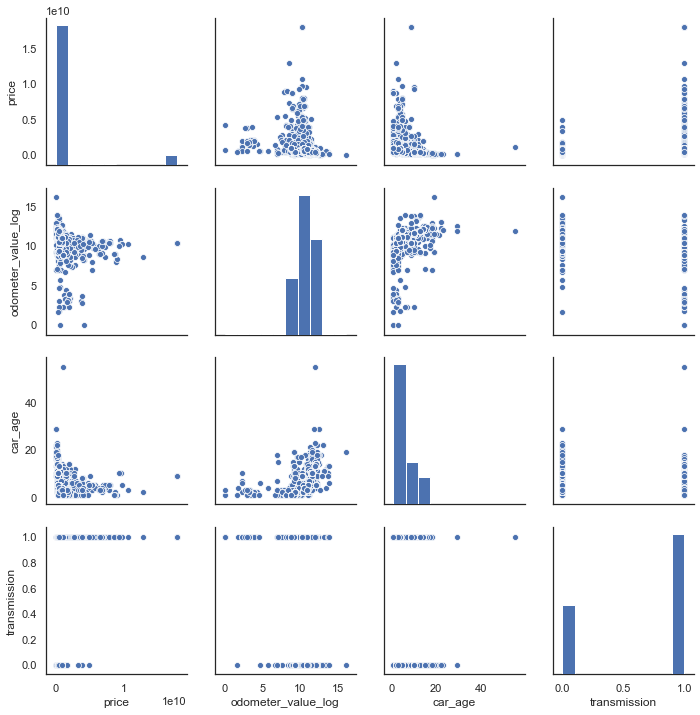

In [50]:
# Visualizing Pairplots of Price vs Other Features and Only Mileage logged

sns.pairplot(df_price_no_brands_only_mileage_logged);

### Section 3.2.2: Normal Price with Logged Mileage and Squared Engine CC

In [51]:
# Creating a copy of the dataframe to work log on
#df_price_no_brands_mileage_logged_squared_engine_cap = df_price_no_brands_only_mileage_logged.copy()

In [52]:
# Square Engine CC
#df_price_no_brands_mileage_logged_squared_engine_cap["engine_squared"] = \
#df_price_no_brands_mileage_logged_squared_engine_cap['engine_capacity'].apply(lambda x: x**2)


In [53]:
#df_price_no_brands_mileage_logged_squared_engine_cap.columns

In [54]:
# Rearrange columns
#df_price_no_brands_mileage_logged_squared_engine_cap = \
#df_price_no_brands_mileage_logged_squared_engine_cap[['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
#       'CAR_AGE', 'OMV', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
#       'NO_OF_OWNERS', 'TRANSMISSION']]

In [55]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
#X = df_price_no_brands_mileage_logged_squared_engine_cap[ ['odometer_value_log', 'car_age',
#       'transmission', 'engine_squared'] ].astype(float)
#X = sm.add_constant(X)
#y = df_price_no_brands_only_mileage_logged['price'].astype(int)


# model / fit / summarize
#import statsmodels.api as sm

#lsm = sm.OLS(y, X)
#results = lsm.fit()
#results.summary()

In [56]:
# Visualizing Pairplots of the distributions

#sns.pairplot(df_price_no_brands_mileage_logged_squared_engine_cap);

In [57]:
# Viewing Corr Matrix of Price vs Independent Variables (only logged mileage and squared engine CC)

#sns.set(style="white")
#data = df_price_no_brands_mileage_logged_squared_engine_cap.corr()

# Generate a mask for the upper triangle
#mask = np.zeros_like(data, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
#fig, ax = plt.subplots(figsize=(15,15))

# Create a custom color palette
#cmap = \
#sns.diverging_palette(133, 10,
#                      as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Green = Good (low correlation), Red = Bad (high correlation) between the independent variables

# Plot the heatmap
#sns.heatmap(data, mask=mask, annot=True, 
#            square=True, cmap=cmap , vmin=-1, vmax=1,ax=ax);

# Prevent Heatmap Cut-Off Issue
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)

### Section 3.2.3: Logged Price with Logged Mileage and Squared Engine CC

In [58]:
#df_logged_price_no_brands_mileage_logged_squared_engine_cap = df_price_no_brands_mileage_logged_squared_engine_cap.copy()

In [59]:
# Logging Price
#df_logged_price_no_brands_mileage_logged_squared_engine_cap['price_log'] =\
#df_logged_price_no_brands_mileage_logged_squared_engine_cap['price'].apply(np.log)

In [60]:
# Rearrange columns
#df_logged_price_no_brands_mileage_logged_squared_engine_cap = \
#df_logged_price_no_brands_mileage_logged_squared_engine_cap[['price_log', 'odometer_value_log', 'car_age',
#       'transmission', 'engine_squared']]

In [61]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
#X = df_logged_price_no_brands_mileage_logged_squared_engine_cap[ ['odometer_value_log', 'car_age',
#       'transmission', 'engine_squared'] ].astype(float)
#X = sm.add_constant(X)
#y = df_logged_price_no_brands_mileage_logged_squared_engine_cap['price_log'].astype(float)


# model / fit / summarize
#import statsmodels.api as sm

#lsm = sm.OLS(y, X)
#results = lsm.fit()
#results.summary()

### Section 3.2.3: Logged Price with Logged Mileage only (no engine squared)

In [62]:
df_logged_price_no_brands_only_mileage_logged = df_price_no_brands_only_mileage_logged.copy()

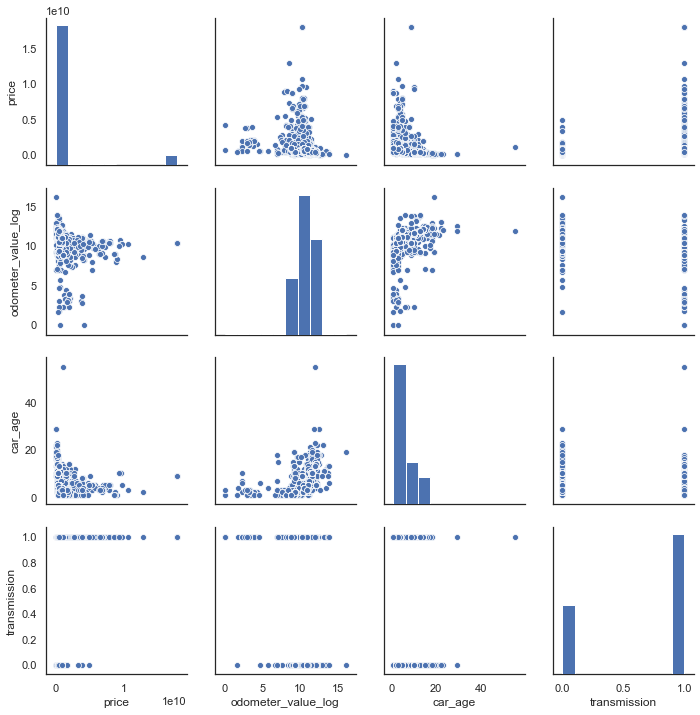

In [63]:
sns.pairplot(df_logged_price_no_brands_only_mileage_logged);
plt.savefig("log_price_and_mileage.png")

In [64]:
# Logging Price
df_logged_price_no_brands_only_mileage_logged['price'] = df_logged_price_no_brands_only_mileage_logged['price'].apply(np.log)

# Renaming column
df_logged_price_no_brands_only_mileage_logged.rename(columns={'price':'price_log'},inplace=True)

In [65]:
df_logged_price_no_brands_only_mileage_logged.columns

Index(['price_log', 'odometer_value_log', 'car_age', 'transmission'], dtype='object')

In [66]:
df_logged_price_no_brands_only_mileage_logged.head()

,price_log,odometer_value_log,car_age,transmission
0,20.225685,9.615805,2,1
1,20.183698,11.925035,4,0
2,20.069339,11.314475,6,1
3,19.968243,11.751942,11,1
4,19.718144,11.156251,5,0


In [67]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_logged_price_no_brands_only_mileage_logged[['odometer_value_log', 'car_age',
       'transmission'] ].astype(float)
X = sm.add_constant(X)
y = df_logged_price_no_brands_only_mileage_logged['price_log'].astype(float)


# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

D:\Application\Anaconda2\envs\py3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
D:\Application\Anaconda2\envs\py3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
D:\Application\Anaconda2\envs\py3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
D:\Application\Anaconda2\envs\py3\lib\site-packages\scipy\stats\stats.py:1463: RuntimeWarning: invalid value encountered in sign
  term2 = np.sign(denom) * np.where(denom == 0.0, np.nan,
D:\Application\Anaconda2\envs\py3\lib\site-packages\statsmodels\regression\linear_model.py:1594: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 06 Jan 2020   Prob (F-statistic):                nan
Time:                        16:40:50   Log-Likelihood:                    nan
No. Observations:               17027   AIC:                               nan
Df Residuals:                   17023   BIC:                               nan
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                     inf        nan        nan        nan         nan         nan
odometer_value_log       -inf        nan        nan        nan         nan         nan
car_age                   inf        nan        nan        nan         nan         nan
transmission              inf        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         181.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### R^2 Summary from Linear Regression Models
Price vs Original Independent Variables:  
R^2: **0.820**  
R^2 Adjusted: **0.820**  
df_price_no_brands
  
Price vs Independent Variables (Logged Mileage and Squared Engine CC):  
R^2: **0.824**  
R^2 Adjusted: **0.824**  
df_price_no_brands_mileage_logged_squared_engine_cap
    
Logged Price vs Independent Variables (Logged Mileage and Squared Engine CC (engine squared became irrelevant):
R^2: **0.897**     
R^2 Adjusted: **0.897**   
df_logged_price_no_brands_mileage_logged_squared_engine_cap
  
Logged Price vs Independent Variables (Logged Mileage):
R^2: **0.898**     
R^2 Adjusted: **0.898**  
df_logged_price_no_brands_only_mileage_logged

## Section 3.3: Analysis of Car Brands, Vehicle Types, Brand Categorization

### 3.3.1: Further breaking down dataframe into finalized features (with log price, log mileage)

In [68]:
df_finalized_features = df_clean2.copy()

In [69]:
# Applying log to the desired features
df_finalized_features['price'] = df_clean2['price'].apply(np.log)
df_finalized_features['odometer_value'] = df_clean2['odometer_value'].apply(np.log)


# Renaming features
df_finalized_features.rename(columns={'price':'price_log',
                                     'odometer_value':'odometer_value_log'},inplace=True)

In [70]:
df_finalized_features.columns

Index(['manufacturer_name', 'model_name', 'body_type', 'production_year',
       'number_of_seat', 'odometer_value_log', 'price_log', 'transmission',
       'car_age', 'Intercept', 'body_type[T.City Car]', 'body_type[T.Coupe]',
       'body_type[T.Hatchback]', 'body_type[T.MPV]',
       'body_type[T.Pick-up Truck]', 'body_type[T.SUV]', 'body_type[T.Sedan]',
       'body_type[T.Special Purpose]', 'body_type[T.Sport Car]',
       'body_type[T.Truck]', 'body_type[T.Van/Minivan]'],
      dtype='object')

In [71]:
# Rearranging Columns and removing unwanted variables
#df_finalized_features = df_finalized_features[['BRAND','PRICE_LOG', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
#       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
#       'NO_OF_OWNERS', 'TRANSMISSION', 'Intercept', 'VEHICLE_TYPE[T.Luxury Sedan]',
#       'VEHICLE_TYPE[T.MPV]', 'VEHICLE_TYPE[T.Mid-Sized Sedan]',
#       'VEHICLE_TYPE[T.SUV]', 'VEHICLE_TYPE[T.Sports Car]',
#       'VEHICLE_TYPE[T.Stationwagon]']]

In [72]:
df_logged_price_no_brands_only_mileage_logged.columns

Index(['price_log', 'odometer_value_log', 'car_age', 'transmission'], dtype='object')

In [73]:
df_finalized_features.columns

Index(['manufacturer_name', 'model_name', 'body_type', 'production_year',
       'number_of_seat', 'odometer_value_log', 'price_log', 'transmission',
       'car_age', 'Intercept', 'body_type[T.City Car]', 'body_type[T.Coupe]',
       'body_type[T.Hatchback]', 'body_type[T.MPV]',
       'body_type[T.Pick-up Truck]', 'body_type[T.SUV]', 'body_type[T.Sedan]',
       'body_type[T.Special Purpose]', 'body_type[T.Sport Car]',
       'body_type[T.Truck]', 'body_type[T.Van/Minivan]'],
      dtype='object')

### 3.3.2: Joining Brand Dummy Variables into Main Dataframe

In [74]:
# Creating a new DataFrame for this Brand Categorization
df_categorized_car_brands = df_finalized_features.copy()

In [75]:
print(df_categorized_car_brands['manufacturer_name'].value_counts())
print(len(df_categorized_car_brands['manufacturer_name'].value_counts()))

Toyota           8693
Kia              2228
Mercedes-Benz    1207
Hyundai          1182
Ford             1178
Mazda            1098
Rolls-Royce      1046
Lexus              70
Honda              55
Chevrolet          54
Mitsubishi         32
LandRover          28
BMW                25
Audi               23
Nissan             23
Daewoo             17
Suzuki             13
Cadillac            7
Porsche             7
Bentley             5
Isuzu               4
Jaguar              4
Acura               4
Peugeot             3
Renault             3
Cửu Long            2
Mini                2
Zotye               2
Volkswagen          2
Samco               1
FAW                 1
Thaco               1
Fiat                1
Maserati            1
Fuso                1
Subaru              1
Hino                1
Infiniti            1
Ssangyong           1
Name: manufacturer_name, dtype: int64
39


In [76]:
# Creating the relevant columns
df_categorized_car_brands['EXOTIC'] = 0 # Create EXOTIC column
df_categorized_car_brands["ULTRA_LUXURY"] = 0
df_categorized_car_brands["LUXURY"] = 0
df_categorized_car_brands["MID_LEVEL"] = 0
df_categorized_car_brands["ECONOMY"] = 0

In [77]:
# Labelling Car Brands into Exotic
df_categorized_car_brands.loc[(df_clean2['manufacturer_name'] == "Aston Martin") | 
              (df_clean2['manufacturer_name'] == "Ferrari") |
              (df_clean2['manufacturer_name'] == "Lamborghini") |
              (df_clean2['manufacturer_name'] == "McLaren") |
              (df_clean2['manufacturer_name'] == "Hummer"),
              'EXOTIC'] = 1 

# Labelling Car Brands into Ultra Luxury
df_categorized_car_brands.loc[(df_clean2['manufacturer_name'] == "Bentley") | 
              (df_clean2['manufacturer_name'] == "Land Rover") |
              (df_clean2['manufacturer_name'] == "Maserati") |
              (df_clean2['manufacturer_name'] == "Porsche") |
              (df_clean2['manufacturer_name'] == "Rolls-Royce"), 
              "ULTRA_LUXURY"] = 1 

# Labelling Car Brands into Luxury

df_categorized_car_brands.loc[(df_clean2['manufacturer_name'] == "Audi") | 
              (df_clean2['manufacturer_name'] == "BMW") |
              (df_clean2['manufacturer_name'] == "Jeep") |
              (df_clean2['manufacturer_name'] == "Lexus") |
              (df_clean2['manufacturer_name'] == "Lotus") |
              (df_clean2['manufacturer_name'] == "Mercedes-Benz") |
              (df_clean2['manufacturer_name'] == "Volvo") |
              (df_clean2['manufacturer_name'] == "Peugeot"), 
              "LUXURY"] = 1 


# Labelling Car Brands into Mid-Level

df_categorized_car_brands.loc[(df_clean2['manufacturer_name'] == "Infiniti") |
              (df_clean2['manufacturer_name'] == "MINI") |
              (df_clean2['manufacturer_name'] == "Volkswagen") |
              (df_clean2['manufacturer_name'] == "Renault") |
              (df_clean2['manufacturer_name'] == "Peugeot"), 
              "MID_LEVEL"] = 1 

# (df_clean2['manufacturer_name'] == "Opel") & "Alfa Romeo" will be considered as "Others" because it is not a very common brand in Singapore

# Labelling Car Brands into Economy

df_categorized_car_brands.loc[(df_clean2['manufacturer_name'] == "Chevrolet") | 
              (df_clean2['manufacturer_name'] == "Citroen") |
              (df_clean2['manufacturer_name'] == "Ford") |
              (df_clean2['manufacturer_name'] == "Honda") |
              (df_clean2['manufacturer_name'] == "Hyundai") |
              (df_clean2['manufacturer_name'] == "Kia") |
              (df_clean2['manufacturer_name'] == "Mazda") |
              (df_clean2['manufacturer_name'] == "Mitsubishi") |
              (df_clean2['manufacturer_name'] == "Nissan") |
              (df_clean2['manufacturer_name'] == "Suzuki") |
              (df_clean2['manufacturer_name'] == "Toyota"),
              "ECONOMY"] = 1

# (df_clean2['manufacturer_name'] == "Ssangyong") will be considered as "Others" because it is not a common brand in Singapore

# Changing Uncommon Car brands to "Others"
df_categorized_car_brands.loc[(df_clean2['manufacturer_name'] == 'Opel') |
                  (df_clean2['manufacturer_name'] == 'Ssangyong') |
                  (df_clean2['manufacturer_name'] == 'Proton') |
                  (df_clean2['manufacturer_name'] == 'Daihatsu') |
                  (df_clean2['manufacturer_name'] == 'Fiat') |
                  (df_clean2['manufacturer_name'] == 'Alfa Romeo') |
                  (df_clean2['manufacturer_name'] == 'Skoda') |
                  (df_clean2['manufacturer_name'] == 'Hummer')|
                  (df_clean2['manufacturer_name'] == 'Aston Martin')|
                  (df_clean2['manufacturer_name'] == 'Lotus')|
                  (df_clean2['manufacturer_name'] == 'Ford')|
                  (df_clean2['manufacturer_name'] == 'Jeep'), 
                  'manufacturer_name'] = "Others"



# Group uncommon cars into "Others". There are too many brands to work with.

In [78]:
print(df_categorized_car_brands['manufacturer_name'].value_counts())
print(len(df_categorized_car_brands['manufacturer_name'].value_counts()))

Toyota           8693
Kia              2228
Mercedes-Benz    1207
Hyundai          1182
Others           1180
Mazda            1098
Rolls-Royce      1046
Lexus              70
Honda              55
Chevrolet          54
Mitsubishi         32
LandRover          28
BMW                25
Audi               23
Nissan             23
Daewoo             17
Suzuki             13
Cadillac            7
Porsche             7
Bentley             5
Isuzu               4
Acura               4
Jaguar              4
Renault             3
Peugeot             3
Zotye               2
Cửu Long            2
Mini                2
Volkswagen          2
Thaco               1
Infiniti            1
Hino                1
Samco               1
FAW                 1
Maserati            1
Subaru              1
Fuso                1
Name: manufacturer_name, dtype: int64
37


##### Brand Dummy Variables Creation

In [79]:
x_brand_dummy = patsy.dmatrix('manufacturer_name', data=df_categorized_car_brands, return_type='dataframe')
x_brand_dummy.head()

,Intercept,manufacturer_name[T.Audi],manufacturer_name[T.BMW],manufacturer_name[T.Bentley],manufacturer_name[T.Cadillac],manufacturer_name[T.Chevrolet],manufacturer_name[T.Cửu Long],manufacturer_name[T.Daewoo],manufacturer_name[T.FAW],manufacturer_name[T.Fuso],...,manufacturer_name[T.Porsche],manufacturer_name[T.Renault],manufacturer_name[T.Rolls-Royce],manufacturer_name[T.Samco],manufacturer_name[T.Subaru],manufacturer_name[T.Suzuki],manufacturer_name[T.Thaco],manufacturer_name[T.Toyota],manufacturer_name[T.Volkswagen],manufacturer_name[T.Zotye]
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
df_categorized_car_brands.drop('Intercept',axis=1,inplace=True)# Drop intercept because already have intercept from previous vehicle type
df_categorized_car_brands = df_categorized_car_brands.join(x_brand_dummy)
df_categorized_car_brands

,manufacturer_name,model_name,body_type,production_year,number_of_seat,odometer_value_log,price_log,transmission,car_age,body_type[T.City Car],...,manufacturer_name[T.Porsche],manufacturer_name[T.Renault],manufacturer_name[T.Rolls-Royce],manufacturer_name[T.Samco],manufacturer_name[T.Subaru],manufacturer_name[T.Suzuki],manufacturer_name[T.Thaco],manufacturer_name[T.Toyota],manufacturer_name[T.Volkswagen],manufacturer_name[T.Zotye]
0,Kia,cerato,Sedan,2018,5,9.615805,20.225685,1,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Toyota,innova,MPV,2016,7,11.925035,20.183698,0,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Toyota,innova,MPV,2014,8,11.314475,20.069339,1,6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Toyota,corolla-altis,Sedan,2009,5,11.751942,19.968243,1,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Kia,rio,Sedan,2015,5,11.156251,19.718144,0,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20535,Others,ranger,Pick-up Truck,2017,5,10.915088,20.487544,1,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20536,Toyota,fortuner,SUV,2017,7,10.915088,20.601098,0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20537,Rolls-Royce,phantom,Sedan,2011,4,10.308953,23.608067,1,9,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20538,Toyota,fortuner,SUV,2019,7,8.853665,20.752825,1,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 3.3.4 : Only Brand Segregation

In [81]:
df_categorized_car_brands.columns

Index(['manufacturer_name', 'model_name', 'body_type', 'production_year',
       'number_of_seat', 'odometer_value_log', 'price_log', 'transmission',
       'car_age', 'body_type[T.City Car]', 'body_type[T.Coupe]',
       'body_type[T.Hatchback]', 'body_type[T.MPV]',
       'body_type[T.Pick-up Truck]', 'body_type[T.SUV]', 'body_type[T.Sedan]',
       'body_type[T.Special Purpose]', 'body_type[T.Sport Car]',
       'body_type[T.Truck]', 'body_type[T.Van/Minivan]', 'EXOTIC',
       'ULTRA_LUXURY', 'LUXURY', 'MID_LEVEL', 'ECONOMY', 'Intercept',
       'manufacturer_name[T.Audi]', 'manufacturer_name[T.BMW]',
       'manufacturer_name[T.Bentley]', 'manufacturer_name[T.Cadillac]',
       'manufacturer_name[T.Chevrolet]', 'manufacturer_name[T.Cửu Long]',
       'manufacturer_name[T.Daewoo]', 'manufacturer_name[T.FAW]',
       'manufacturer_name[T.Fuso]', 'manufacturer_name[T.Hino]',
       'manufacturer_name[T.Honda]', 'manufacturer_name[T.Hyundai]',
       'manufacturer_name[T.Infiniti]', '

In [82]:
df_categorized_car_brands[['manufacturer_name', 'model_name', 'body_type', 'production_year',
       'number_of_seat', 'odometer_value_log', 'color_body', 'engine_fuel',
       'engine_capacity', 'drivetrain', 'price_log', 'transmission', 'car_age', 'EXOTIC', 'ULTRA_LUXURY', 'LUXURY',
       'MID_LEVEL', 'ECONOMY']]

KeyError: "['engine_capacity', 'color_body', 'engine_fuel', 'drivetrain'] not in index"

In [ ]:
# Finding out new R^2 from log transformations of Log Price and Log Independent Variables (except Mileage)

# Slicing Variables
#df_categorized_car_brands.dropna(inplace=True)
X = df_categorized_car_brands[[ 'odometer_value_log', 'transmission', 'car_age', 'EXOTIC', 'ULTRA_LUXURY', 'LUXURY',
       'MID_LEVEL', 'ECONOMY']]
X = sm.add_constant(X)
y = df_categorized_car_brands['price_log'].astype(float)

# Initially my coefficients were difficult to interpret. 
# Therefore I transformed it using log for better explanation purposes

# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

### R^2 Summary from Linear Regression Models
Price vs Original Independent Variables:  
R^2: **0.820**  
R^2 Adjusted: **0.820**  
df_price_no_brands
  
Price vs Independent Variables (Logged Mileage and Squared Engine CC):  
R^2: **0.824**  
R^2 Adjusted: **0.824**  
df_price_no_brands_mileage_logged_squared_engine_cap
    
Logged Price vs Independent Variables (Logged Mileage and Squared Engine CC (engine squared became irrelevant):
R^2: **0.897**     
R^2 Adjusted: **0.897**   
df_logged_price_no_brands_mileage_logged_squared_engine_cap
  
Logged Price vs Independent Variables (Logged Mileage):
R^2: **0.898**     
R^2 Adjusted: **0.898**  
df_logged_price_no_brands_only_mileage_logged  
  
Logged Price vs Independent Variables (Logged Mileage) + Categorized Car Brands:
R^2: **0.921**     
R^2 Adjusted: **0.921**  
df_categorized_car_brands

## Section 4.2: Cross-Validation Using Models other than LR

### Section 4.2.1 : Using LassoCV to find best Alpha Value for L1 Regularization

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_categorized_car_brands[[ 'odometer_value_log', 'transmission', 'car_age', 'EXOTIC', 'ULTRA_LUXURY', 'LUXURY',
       'MID_LEVEL', 'ECONOMY']]
y = df_categorized_car_brands['price_log']

# hold out 20% of the data for final testing

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state=20)

In [ ]:

## Scale the data (a MUST if you're doing regularization)
std = StandardScaler()
std.fit(X_train.values)

## Scale the Predictors on both the train/validation (the whole 80%) and test set (the whole 20%)
X_train_scaled = std.transform(X_train.values)
X_val_scaled = std.transform(X_val.values)

# LassoCV does 2 things for you. It trains your model, and it also chooses the best lambda/alpha for you.  
# But of course, you have to feed it a list of lambdas to try.

# The best part about LambdaCV is that it does all 3 for you:
# Fit
# Finding best lambda
# Doing Cross-Validation

from sklearn.model_selection import KFold   #Kfold will allow you to do cross validation

# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-3,3,200) # Defining a vector of lambdas (alpha) to try from
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)  # Creating a partitioned randomized-state data

lasso_model = LassoCV(alphas = alphavec, cv=kf)  # If you want to use Ridge, use RidgeCV
lasso_model.fit(X_train_scaled, y_train)

# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

In [ ]:
# These are the (standardized) coefficients found when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

In [ ]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Make predictions on the test set using the new model 
# (the model is already using the best alpha. It is a LassoCV initialization)
val_set_pred = lasso_model.predict(X_val_scaled)

# Find the MAE and R^2 on the test set using this model
print(f"LassoCV Best Lambda (alpha): {lasso_model.alpha_}")
print(f"LassoCV RMSE: {RMSE(y_val, val_set_pred)}")
print(f"LassoCV R^2 Score: {r2_score(y_val, val_set_pred)}")

### Section 4.2.2: Using RidgeCV to find best Alpha Value for L2 Regularization

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_categorized_car_brands[[ 'odometer_value_log', 'transmission', 'car_age', 'EXOTIC', 'ULTRA_LUXURY', 'LUXURY',
       'MID_LEVEL', 'ECONOMY']]
y = df_categorized_car_brands['price_log']


# hold out 20% of the data for final testing

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state=20)

In [ ]:
# Use RidgeCV to find the optimal ALPHA value for L2 regularization

## Scale the data (a MUST if you're doing regularization)
std = StandardScaler()
std.fit(X_train.values)

# Scale the Predictors on both the train and validation set (for RidgeCV)
X_train_scaled = std.transform(X_train.values)
X_val_scaled = std.transform(X_val.values)

# Run the cross-validation, find the best alpha, refit the model on all the data with that alpha (RidgeCV does this for you)
alphavec = 10 ** np.linspace(-3,3,200) # alpha varies from 0.001 to 1000
kf = KFold(n_splits=5, shuffle=True, random_state=1000)

ridge_model = RidgeCV(alphas=alphavec, cv=kf)
ridge_model.fit(X_train_scaled, y_train)  # Fit your scaled train input and your y train values

# This is the best alpha value found
ridge_model.alpha_

In [ ]:
# display all coefficients in the model with optimal alpha
list(zip(X_train.columns, ridge_model.coef_))

In [ ]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Make predictions on the test set using the new model and save it into a variable
val_set_pred = lasso_model.predict(X_val_scaled)


# Find the MAE and R^2 on the test set using this model
print(f"Best Lambda (alpha) RidgeCV: {ridge_model.alpha_}")
print(f"RidgeCV MAE: {RMSE(y_val, val_set_pred)}")
print(f"RidgeCV R^2 Score: {r2_score(y_val, val_set_pred)}")

### Section 4.2.3: Using ElasticnetCV to find best Alpha Value 

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_categorized_car_brands[[ 'odometer_value_log', 'transmission', 'car_age', 'EXOTIC', 'ULTRA_LUXURY', 'LUXURY',
       'MID_LEVEL', 'ECONOMY']]
y = df_categorized_car_brands['price_log']

# hold out 20% of the data for final testing

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state=20)

In [ ]:
# Using ElasticNetCV to find the optimal ALPHA value
# Scale the data as before (scaling is a must for regularization)
std = StandardScaler()
std.fit(X_train.values) # (60% of the data)

# Scale the Predictors on both the train and validation set
X_train_scaled = std.transform(X_train.values)
X_val_scalred = std.transform(X_val.values)

# Run the cross-validation, find the best alpha, refit the model and all the data using that alpha (ElasticNetCV does this for you)
alphavec = 10 ** np.linspace(-3,3,200)  # alpha varies from 0.001 to 1000
kf = KFold(n_splits=5, shuffle=True, random_state=1000)

elasticnet_model = ElasticNetCV(alphas = alphavec, cv=kf)
elasticnet_model.fit(X_train_scaled, y_train)  # Fitting standardscaled input and true y values into model to train it

elasticnet_model.alpha_

In [ ]:
# display all coefficients in the model with optimal alpha
list(zip(X_train.columns, elasticnet_model.coef_))

In [ ]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Use this model to do prediction on a validation data set
val_set_pred = elasticnet_model.predict(X_val_scaled)

# Find the MAE and R^2 on the test set using this model
print(f'Best Lambda (Alpha) ElasticNetCV: {elasticnet_model.alpha_}')
print(f'ElasticNetCV RMSE: {RMSE(y_val, val_set_pred)}')  # mae is a defined function above
print(f'ElasticNetCV R^2 Score: {r2_score(y_val, val_set_pred)}')  # r2_score is an imported module

### Section 4.2.3: Summary from the above Train-Validation Sets

LassoCV Best Lambda (alpha): 0.0032550885998350564  
LassoCV RMSE: 0.2060456832969135  
LassoCV R^2 Score: 0.8908070012251001  
  
Best Lambda (alpha) RidgeCV: 21.96385372416547  
RidgeCV MAE: 0.2060456832969135  
RidgeCV R^2 Score: 0.8908070012251001  
  
Best Lambda (Alpha) ElasticNetCV: 0.006080224261649421  
ElasticNetCV RMSE: 0.20546000914492651    
ElasticNetCV R^2 Score: 0.8914268698533193  

### Section 4.3: Picking Model with the best R^2 score (Train and Cross-Validation)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_categorized_car_brands[[ 'odometer_value_log', 'transmission', 'car_age', 'EXOTIC', 'ULTRA_LUXURY', 'LUXURY',
       'MID_LEVEL', 'ECONOMY']]
y = df_categorized_car_brands['price_log']

# Create 80% of train data. The code below will automate the cross-validation
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

In [ ]:
## cross validation using KFold (on the 100% dataset, without manually splitting)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))


#Feature transform/scaling so that we can run our ridge/lasso/elasticnet model 
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val.values)

#Feature transform/scaling so that we can run our poly model 
poly = PolynomialFeatures(degree=2) 
X_train_val_poly = poly.fit_transform(X_train_val.values)

kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

lm = LinearRegression()
cvs_lm = cross_val_score(lm, X_train_val, y_train_val, cv=kf, scoring='r2')
print("Linear Regression Cross Val Score: {}".format(cvs_lm))
# print(f'ElasticNetCV RMSE: {round(RMSE(y_val, val_set_pred),3)}')
print('Linear regression cv R^2:', round(np.mean(cvs_lm),3), '+-', round(np.std(cvs_lm),3),'\n' )


lm_ridge = Ridge(alpha=21.96385372416547 )
cvs_ridge = cross_val_score(lm_ridge, X_train_val_scaled, y_train_val, cv=kf, scoring='r2')
print("Ridge Cross Val Score: {}".format(cvs_ridge))
# print(f'ElasticNetCV RMSE: {round(RMSE(y_val, val_set_pred),3)}')
print('Ridge regression cv R^2:', round(np.mean(cvs_ridge),3), '+-', round(np.std(cvs_ridge),3),'\n' )



lm_lasso = Lasso(alpha=0.0032550885998350564)
cvs_lasso = cross_val_score(lm_lasso, X_train_val_scaled, y_train_val, cv=kf, scoring='r2')
print("Lasso Cross Val Score: {}".format(cvs_lasso))
# print(f'ElasticNetCV RMSE: {round(RMSE(y_val, val_set_pred),3)}')
print('Lasso regression cv R^2:', round(np.mean(cvs_lasso),3), '+-', round(np.std(cvs_lasso),3),'\n' )


lm_elasticnet = ElasticNet(alpha=0.006080224261649421 )
cvs_elasticnet = cross_val_score(lm_elasticnet, X_train_val_scaled, y_train_val, cv=kf, scoring='r2')
print("Elastic Net Cross Val Score: {}".format(cvs_elasticnet))
# print(f'ElasticNetCV RMSE: {round(RMSE(y_val, val_set_pred),3)}')
print('ElasticNet regression cv R^2:', round(np.mean(cvs_elasticnet),3), '+-', round(np.std(cvs_elasticnet),3),'\n' )


lm_poly = LinearRegression()
cvs_poly = cross_val_score(lm_poly, X_train_val_poly, y_train_val, cv=kf, scoring='r2')
print("Poly Regression Cross Val Score: {}".format(cvs_poly))
# print(f'ElasticNetCV RMSE: {round(RMSE(y_val, val_set_pred),3)}')
print('Degree 2 polynomial Regression cv R^2:', round(np.mean(cvs_poly),3), '+-', round(np.std(cvs_poly),3) )

In [ ]:
# From the code above, it seems like Linear Regression provides similar results as compared to the rest.
# Therefore, will choose to use linear regression for it's simplicity and ease of use

# Section 5: Model Testing (On whole DataSet)

## Section 5.1: Training Model on 80% DataSet

In [ ]:
df_categorized_car_brands.columns

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_categorized_car_brands[[ 'odometer_value_log', 'transmission', 'car_age', 'EXOTIC', 'ULTRA_LUXURY', 'LUXURY',
       'MID_LEVEL', 'ECONOMY']]
y = df_categorized_car_brands['price_log']

# Create 80% of train data. The code below will automate the cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=20)

In [ ]:
# model / fit / summarize
import statsmodels.api as sm

lm_model = LinearRegression()
lm_model = sm.OLS(y_train, X_train)  # no need sm.add_constant because there's already an intercept
results = lm_model.fit()
results.summary()

### R^2 Summary from Linear Regression Models
**------------------**  
**Best Data Set (80% of data on train, 20% on test)**  
Logged Price vs Independent Variables (Logged Mileage) + Categorized Car Brands:
R^2: **0.921**     
R^2 Adjusted: **0.921**  
df_categorized_car_brands

**---------------------**

Price vs Original Independent Variables:  
R^2: **0.820**  
R^2 Adjusted: **0.820**  
df_price_no_brands
  
Price vs Independent Variables (Logged Mileage and Squared Engine CC):  
R^2: **0.824**  
R^2 Adjusted: **0.824**  
df_price_no_brands_mileage_logged_squared_engine_cap
    
Logged Price vs Independent Variables (Logged Mileage and Squared Engine CC (engine squared became irrelevant):
R^2: **0.897**     
R^2 Adjusted: **0.897**   
df_logged_price_no_brands_mileage_logged_squared_engine_cap
  
Logged Price vs Independent Variables (Logged Mileage):
R^2: **0.898**     
R^2 Adjusted: **0.898**  
df_logged_price_no_brands_only_mileage_logged  
  
Logged Price vs Independent Variables (Logged Mileage) + Categorized Car Brands:
R^2: **0.921**     
R^2 Adjusted: **0.921**  
df_categorized_car_brands

## Section 5.2: Testing Model on 20% DataSet

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

# Create prediction variable for test set
model_test_pred = results.predict(X_test)

# Check accuracy of test
print("Linear Regression Test Scores:\n")
print("Linear Regression MAE: {}".format(mae(y_test, model_test_pred))) # MAE
print("Linear Regression MSE: {}".format(mean_squared_error(y_test, model_test_pred))) # Mean Squared Error (MSE)
print("Linear Regression RMSE: {}".format(RMSE(y_test, model_test_pred))) # Root Mean squared error
print("Linear Regression R2 Score: {}".format(r2_score(y_test, model_test_pred)))# R^2 Score


# Section 6: Checking Linear Regression Assumptions
### Plot 3 Graphs
* residue
* QQ plot

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

## Section 6.1: Plotting the Residuals

In [ ]:
# Defining Graph size
plt.figure(figsize=(10,5))

# Defining the residue and model predicted results
df_categorized_car_brands['PREDICTIONS'] = results.predict(X_test)
df_categorized_car_brands['RESIDUE'] = y_test - model_test_pred

# Plot your predicted values on the x-axis, and your residuals on the y-axis on Residue Plot
plt.scatter(df_categorized_car_brands['PREDICTIONS'], df_categorized_car_brands['RESIDUE'])
plt.title("Residual plot")
plt.xlabel("Prediction")
plt.ylabel("Residuals")

## Section 6.2: QQ Plot

In [ ]:
# Defining the residue and model predicted results
df_categorized_car_brands['PREDICTIONS'] = results.predict(X_test)
df_categorized_car_brands['RESIDUE'] = y_test - model_test_pred

# diagnose/inspect residual normality using QQplot:
plt.figure(figsize=(10,10))
stats.probplot(df_categorized_car_brands['RESIDUE'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

In [ ]:
# 